# Introduction

<img src="https://www.stroke.org/wp-content/uploads/2018/12/tia_horiz.jpg">

The goal for this project is to build a binary classifier that can predict; using some patient information (features), **Transient Ischemic Attack (TIA)**. TIA is like a stroke, producing similar symptoms, but usually lasting only a few minutes and causing no permanent damage. Below is all the details about the features and the target:

- PatientID: Unique ID of patient; Int
- Sex: Gender of patient; String or Categorical Variable
- Age: Age of patient; Int
- Hypertension_Status: 0-no hypertension , 1- suffering from hypertension; Binary 0 or 1
- Heart_Disease_Status: 0-no heart disease, 1- suffering from heart disease; Binary 0 or 1
- Marital_Status: Ever Married; String or Categorical Variable
- Occupation: Type of Work; String or Categorical Variable
- Residence: Area Type of Residence; String or Categorical Variable
- Mean Glucose: Average Glucose Level (after meal)Float
- BMI: Body Mass Index; Float
- Smoking_Status: Patient’s smoking behavior; String or Categorical Variable
- TIA: 0- no TIA , 1 - suffered TIA; Binary 0 or 11 (**Target**)

# Imports

In [650]:
import os
import sys
from warnings import filterwarnings

import feather
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from fastai.tabular import (TabularList, tabular_learner,
                            Categorify, Normalize,
                            FillMissing)
from fastai import FloatList, accuracy
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsemble, BalancedBaggingClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV,
                                     cross_val_predict)
from sklearn.utils import resample
import seaborn as sns
import xgboost as xgb

sys.path.append('../src/')
import utils


%matplotlib inline
plt.style.use('fivethirtyeight')
filterwarnings('ignore')

In [534]:
%reload_ext autoreload
%autoreload 2

# EDA

Let's look at the data and some exploratory data analysis.

In [3]:
PATH = Path('../data/')

In [4]:
# Take a look at file format
!head -10 {PATH / 'raw/TIA_dataset.csv'}

PatientID,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
28674,Female,74.0,1,0,Yes,Self-employed,Urban,205.84,54.6,never smoked,0
64908,Male,79.0,0,1,Yes,Private,Urban,57.08,22.0,formerly smoked,0
63884,Female,37.0,0,0,Yes,Private,Rural,162.96,39.4,never smoked,0
37893,Female,37.0,0,0,Yes,Private,Rural,73.5,26.1,formerly smoked,0


In [5]:
df_raw = pd.read_csv(PATH / 'raw/TIA_dataset.csv')
df_raw.head()

,PatientID,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
0,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
1,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
2,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
3,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
4,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [6]:
df_raw.shape

(29072, 12)

Looks like we have 29,072 samples and 11 features plus the target (TIA).

In [7]:
# Check if there is missing values
df_raw.isnull().sum()

PatientID               0
Sex                     0
Age                     0
Hypertension_Status     0
Heart_Disease_Status    0
Marital_Status          0
Occupation              0
Residence               0
Mean_Glucose            0
BMI                     0
Smoking_Status          0
TIA                     0
dtype: int64

In [8]:
# Check data types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29072 entries, 0 to 29071
Data columns (total 12 columns):
PatientID               29072 non-null int64
Sex                     29072 non-null object
Age                     29072 non-null float64
Hypertension_Status     29072 non-null int64
Heart_Disease_Status    29072 non-null int64
Marital_Status          29072 non-null object
Occupation              29072 non-null object
Residence               29072 non-null object
Mean_Glucose            29072 non-null float64
BMI                     29072 non-null float64
Smoking_Status          29072 non-null object
TIA                     29072 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 2.7+ MB


Good thing we don't have to deal with missing values. All categorical features as `object` which is pandas' representation for strings.

In [9]:
df_raw.describe(include='all')

,PatientID,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
count,29072.000000,29072,29072.000000,29072.000000,29072.000000,29072,29072,29072,29072.000000,29072.000000,29072,29072.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,3,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,17852,NaN,NaN,NaN,21690,18954,14595,NaN,NaN,15747,NaN
mean,37079.469455,NaN,47.671746,0.111482,0.052146,NaN,NaN,NaN,106.403225,30.054166,NaN,0.018850
std,20965.429393,NaN,18.734490,0.314733,0.222326,NaN,NaN,NaN,45.268512,7.193908,NaN,0.135997
min,1.000000,NaN,10.000000,0.000000,0.000000,NaN,NaN,NaN,55.010000,10.100000,NaN,0.000000
25%,19046.750000,NaN,32.000000,0.000000,0.000000,NaN,NaN,NaN,77.627500,25.000000,NaN,0.000000
50%,37444.000000,NaN,48.000000,0.000000,0.000000,NaN,NaN,NaN,92.130000,28.900000,NaN,0.000000
75%,55220.250000,NaN,62.000000,0.000000,0.000000,NaN,NaN,NaN,113.910000,33.900000,NaN,0.000000


In [10]:
# Check the cardinality of categorical features
for col in df_raw.columns:
    if df_raw[col].dtype == 'object':
        print(f'{col}: \n{"-" * (len(col) + 1)}\n{df_raw[col].value_counts()} \n')

Sex: 
----
Female    17852
Male      11213
Other         7
Name: Sex, dtype: int64 

Marital_Status: 
---------------
Yes    21690
No      7382
Name: Marital_Status, dtype: int64 

Occupation: 
-----------
Private          18954
Self-employed     5204
Govt_job          4196
children           617
Never_worked       101
Name: Occupation, dtype: int64 

Residence: 
----------
Urban    14595
Rural    14477
Name: Residence, dtype: int64 

Smoking_Status: 
---------------
never smoked       15747
formerly smoked     7099
smokes              6226
Name: Smoking_Status, dtype: int64 



All the categorical feature are nominal --> no intrinsic orders. Also, most of them have 2-3 factors with the exception of `Occupation` that has 5 categories. Notes also that *Heart_Disease_Status* and *Hypertension_Status* are categorical in nature (Yen/No) but they are provided to us as binary features so we don't have to do anything to them since they are in a good representation.

Positive samples : 1.88%
Negative samples : 98.12%


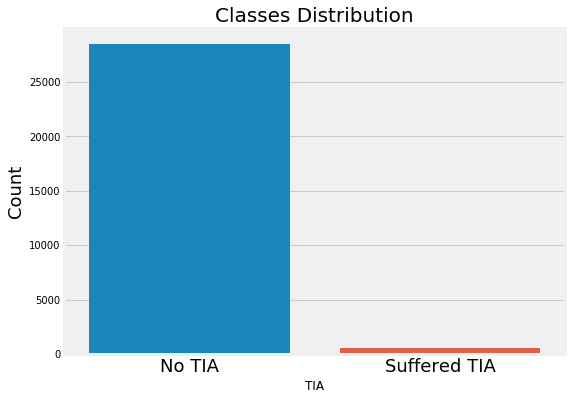

In [11]:
# Plot class distribution
utils.plot_class_dist(df_raw.TIA, x_labels=['No TIA', 'Suffered TIA'])
print(f'Positive samples : {df_raw.TIA.mean():.2%}')
print(f'Negative samples : {1 - df_raw.TIA.mean():.2%}')

Looks like we have a very highly imbalanced dataset. So we may have to use non-traditional methods to deal with that.

In [12]:
cont_features = [
    'Age', 'Mean_Glucose', 'BMI'
]
cat_features = [
    'Sex', 'Marital_Status', 'Occupation',
    'Residence', 'Smoking_Status'
]

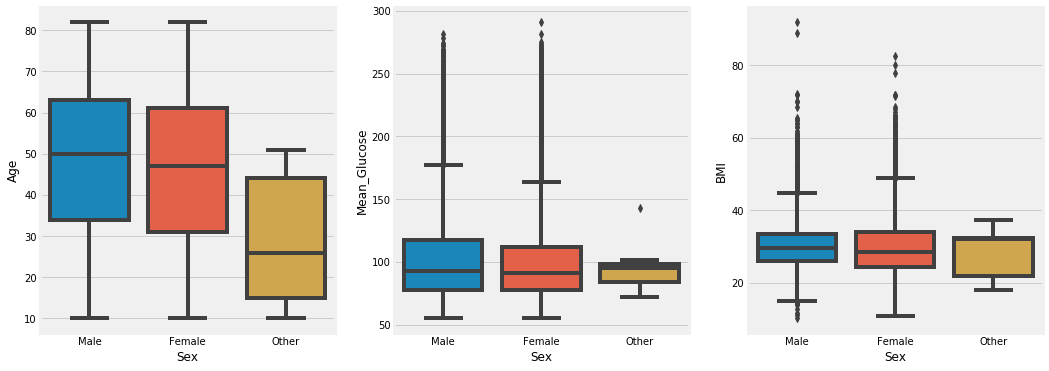

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, col in enumerate(cont_features):
    ax0 = sns.boxplot(x='Sex', y=col, data=df_raw, ax=axs[i])

Patients belong to *Other* category looks they are younger than the rest of the patients (they are only 7).

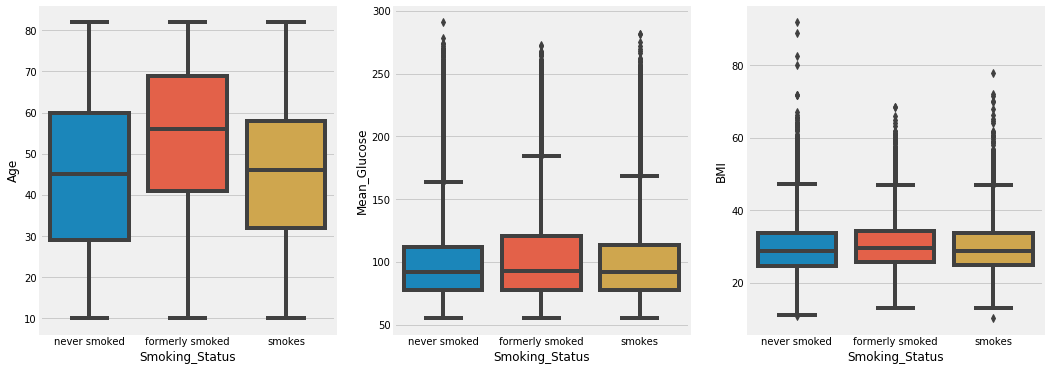

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, col in enumerate(cont_features):
    ax0 = sns.boxplot(x='Smoking_Status', y=col, data=df_raw, ax=axs[i])

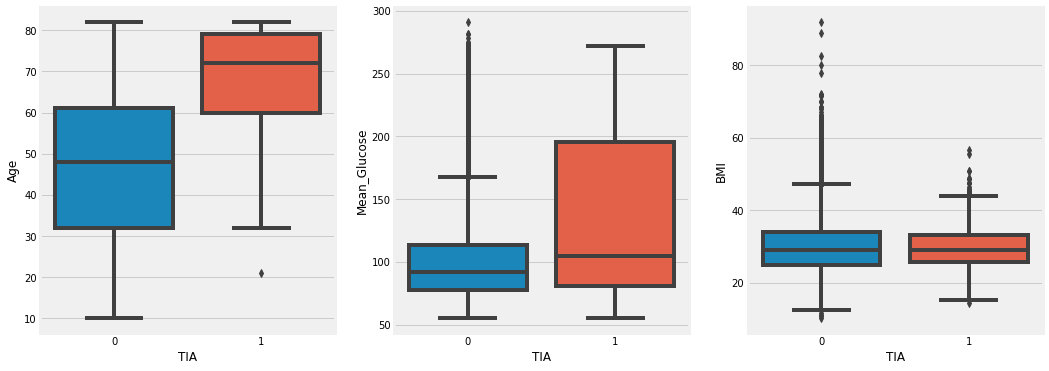

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, col in enumerate(cont_features):
    ax0 = sns.boxplot(x='TIA', y=col, data=df_raw, ax=axs[i])

Looks like older people get TIA at an older age with a median age around 72.

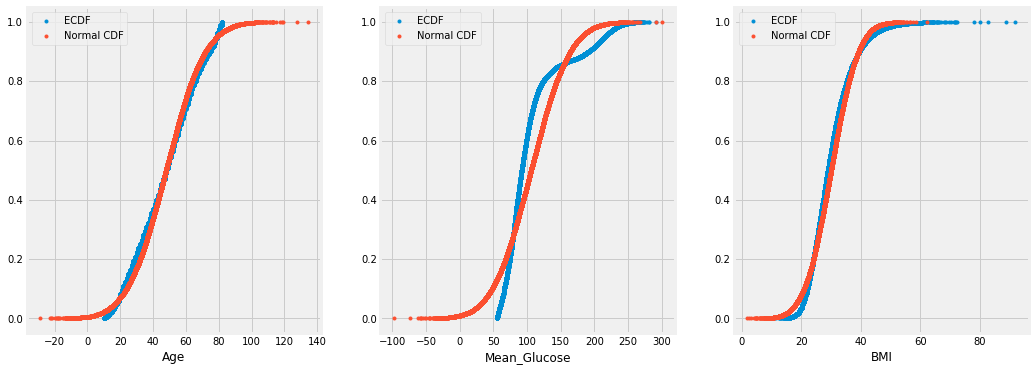

In [16]:
# Check empirical cumulative distribution fn of continuous features
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, col in enumerate(cont_features):
    x, y = utils.get_ecdf(df_raw[col])
    axs[i].plot(x, y, marker='.', linestyle='none')
    # Get normal distributed data
    x_norm = np.random.normal(df_raw[col].mean(), df_raw[col].std(), size=len(x))
    x, y = utils.get_ecdf(x_norm)
    axs[i].plot(x, y, marker='.', linestyle='none')
    axs[i].set_xlabel(col)
    axs[i].legend(['ECDF', 'Normal CDF'])

In [586]:
df.TIA[(df.Hypertension_Status == 1)].mean()

0.04905893242826288

In [587]:
df.TIA[(df.Heart_Disease_Status == 1)].mean()

0.07981530343007916

In [590]:
df.Mean_Glucose[(df.TIA == 1)].mean(), df.Mean_Glucose[(df.TIA == 0)].mean()

(131.04518248175182, 105.92980612817192)

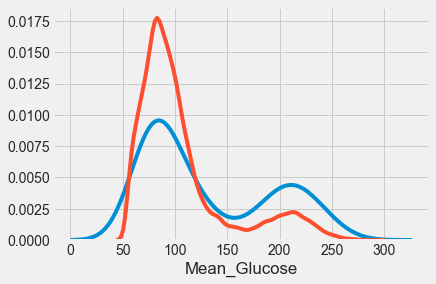

In [602]:
sns.distplot(df.Mean_Glucose[df.TIA == 1], hist=False)
sns.distplot(df.Mean_Glucose[df.TIA == 0], hist=False)

In [610]:
df[df.Mean_Glucose > 160].describe(include='all')

,PatientID,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
count,3914.000000,3914,3914.000000,3914.000000,3914.000000,3914,3914,3914,3914.000000,3914.000000,3914,3914.000000
unique,NaN,2,NaN,NaN,NaN,2,5,2,NaN,NaN,3,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2125,NaN,NaN,NaN,3467,2317,1963,NaN,NaN,1861,NaN
mean,39088.154829,NaN,59.494379,0.247317,0.135922,NaN,NaN,NaN,207.509859,33.524527,NaN,0.046500
std,20710.956991,NaN,15.251067,0.431508,0.342750,NaN,NaN,NaN,23.227439,7.879858,NaN,0.210592
min,7.000000,NaN,10.000000,0.000000,0.000000,NaN,NaN,NaN,160.080000,12.500000,NaN,0.000000
25%,22002.000000,NaN,50.000000,0.000000,0.000000,NaN,NaN,NaN,190.692500,28.000000,NaN,0.000000
50%,40825.500000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,208.015000,32.350000,NaN,0.000000
75%,56602.250000,NaN,71.000000,0.000000,0.000000,NaN,NaN,NaN,223.447500,38.000000,NaN,0.000000


Patients who had TIA have a lot more Mean_Glucose than other patients.

In [591]:
df.BMI[(df.TIA == 1)].mean(), df.BMI[(df.TIA == 0)].mean()

(29.845072992700718, 30.058182583087863)

Looks like Age and BMI features are very close to normal but not the case for Mean_Glucose.

**Notes**:
- No missing values
- Highly Imbalanced data
- 5 Categorical features (nominal) --> No intrinsic order. Check Entity Embeddings to see if it adds value.

In [17]:
# Save data
df_raw.to_feather(PATH / 'raw/raw-data')

# Preprocessing

There is not much of preprocessing to be done here. Below are the steps:
- Remove PatientID feature.
- Split the data into train(70%), validation(15%), and test(15%).
- Standardization of continuous features (Robust Scaler).
- Transform categorical features to one-hot encoding (leave the rest as is).

In [18]:
df = feather.read_dataframe(PATH / 'raw/raw-data')
df.head()

,PatientID,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
0,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
1,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
2,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
3,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
4,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [19]:
# Get all categories and drop first one to avoid dependence that
# may cause issue to some class of models just as logistic regression
categories = []
for col in cat_features:
    categories.append(np.unique(df[col])[1:])
categories

[array(['Male', 'Other'], dtype=object),
 array(['Yes'], dtype=object),
 array(['Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object),
 array(['Urban'], dtype=object),
 array(['never smoked', 'smokes'], dtype=object)]

In [20]:
X = df.drop(columns=['TIA'])
y = df['TIA']
X.shape, y.shape

((29072, 11), (29072,))

In [21]:
# Drop PatientID
X = X.drop(columns=['PatientID'])
X.shape

(29072, 10)

In [22]:
cat_features_idxs = [X.columns.get_loc(col) for col in cat_features]
cont_features_idxs = [X.columns.get_loc(col) for col in cont_features]

In [23]:
# Make column transformer
col_transf = ColumnTransformer(
    [('rob_scaler', RobustScaler(), cont_features_idxs),
    ('ohe', OneHotEncoder(handle_unknown='ignore', categories=categories), cat_features_idxs)
    ], remainder='passthrough'
)

In [24]:
0.15 * X.shape[0]

4360.8

In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=4360,
                                                    stratify=y,
                                                    random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    test_size=4360,
                                                    stratify=y_train,
                                                    random_state=123)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((20352, 10), (4360, 10), (4360, 10), (20352,), (4360,), (4360,))

In [27]:
# Making sure the train and test data have the same class distribution
y_train.mean(), y_valid.mean(), y_test.mean()

(0.018867924528301886, 0.018807339449541285, 0.018807339449541285)

In [28]:
# Save data
X_train.reset_index().to_feather(PATH / 'processed/train-data')
y_train.reset_index().to_feather(PATH / 'processed/train-labels')
X_valid.reset_index().to_feather(PATH / 'processed/valid-data')
y_valid.reset_index().to_feather(PATH / 'processed/valid-labels')
X_test.reset_index().to_feather(PATH / 'processed/test-data')
y_test.reset_index().to_feather(PATH / 'processed/test-labels')

# Modeling

Steps for modeling.
- Evaluate multiple strategies to deal with highly imbalanced data and pick the best one.
- Evaluate 3 classes of algorithms:
    - Shallow algorithms such as RF and XGboost.
    - Build Stacked ensembles using some of the ML algorithms from above with their best hyper-parameters. Note that we may include some algorithms that may not have a good performance by itself such as KNN but sometimes may give a little bit of boost to the stacked ensemble.
    - Use fully connected NN. With this approach, we won't use one-hot encoding for categorical features; however, we will use entity embeddings where each categorical feature will have its own Embedding layer. The output from all the embedding layers will be then concatenated with continuous features which will become the input for the fully connected NN.
- Comparison for all approaches and ML algorithms and pick the best one.
- Feature selection on the best algorithm.
- Refit the algorithm on both training and validation data.
- Report the results after evaluating final algorithm on test data.

The steps below will be used in model evaluation:
- 10-folds cross validation for hyper-parameter tuning.
- Evaluate each algorithm with the best hyper-parameters on validation data and plot ROC curve.
- Nested CV which has proves to reduce bias from using just the best score in hyper-parameter tuning. We'll use a validation set to do another 5 or 10 CV on the tuned models.
- Test set will be used once after we pick the best algorithm and will report the summary.

In [29]:
X_train = feather.read_dataframe(PATH / 'processed/train-data')
y_train = feather.read_dataframe(PATH / 'processed/train-labels')
X_valid = feather.read_dataframe(PATH / 'processed/valid-data')
y_valid = feather.read_dataframe(PATH / 'processed/valid-labels')
X_train = X_train.drop(columns=['index']).values
y_train = y_train.drop(columns=['index']).values.reshape(-1)
X_valid = X_valid.drop(columns=['index']).values
y_valid = y_valid.drop(columns=['index']).values.reshape(-1)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((20352, 10), (20352,), (4360, 10), (4360,))

## Strategies to deal with imbalanced data

The dataset is highly imbalanced where the positive examples (patients who have TIA) were only around 2% while patients who don't have TIA were around %98. Therefore, accuracy is no longer a good measure of performance for different models because if we simply predict all patients to belong to the negative class, we achieve around 98% accuracy. Better metrics for imbalanced data sets are AUC (area under the ROC curve) and f1-score. However, that’s not enough because class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learns a model that optimizes the predictions based on the majority class in the dataset. As a result, we’ll explore different methods to overcome class imbalance problem.

Methods are:
- Under-Sample: Under-sample the majority class with or w/o replacement by making the number of positive and negative examples equal. One of the drawbacks of under-sampling is that it ignores a good portion of training data that has valuable information.

- Over-Sample: Over-sample the minority class with or w/o replacement by making the number of positive and negative examples equal. It’s a lot more computationally expensive than under-sampling. Also, it’s more prune to overfitting due to repeated examples.

- EasyEnsemble: Sample several subsets from the majority class, build a classifier on top of each sampled data, and combine the output of all classifiers.

- Synthetic Minority Oversampling Technique (SMOTE): It over-samples the minority class but using synthesized examples. It operates on feature space not the data space. Here how it works:
    - Compute the k-nearest neighbors for all minority samples.
    - Randomly choose number between 1-k.
    - For each feature:
        - Compute the difference between minority sample and its randomly chosen neighbor (from previous step).
        - Multiply the difference by random number between 0 and 1.
        - Add the obtained feature to the synthesized sample attributes.
    - Repeat the above until we get the number of synthesized samples needed. More information can be found here.

For our task, misclassifying the minority class (false negative) is a lot more dangerous than misclassifying the majority class (false positive). As a result, we can use class_weight that changes the weight of misclassifying positive example in the loss function. Also, we can use different cut-offs to assign patients to classes. By default, 0.5 is the cut-off.

To evaluate all of the above methods, I'll use `RandomForestClassifier` because:
- It is a robust algorithm: It doesn't assume any kind of relationship or the data is normally distributed or to specify feature interactions.
- It doesn't require a lot of feature engineering.
- It is also not very sensitive to outliers.

Therefore, we'll first do hyper-parameter tuning on each method so that we make sure we're not using bad values.

### Strategies to Deal with Imbalanced Data

In [30]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))

# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))

print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (20352, 10) (20352,)
Upsampled shape: (39936, 10) (39936,)
Downsampled shape: (768, 10) (768,)


In [31]:
# Build random forest classifier
methods_data = {'Original': (X_train, y_train),
                'Upsampled': (X_train_u, y_train_u),
                'Downsampled': (X_train_d, y_train_d)}
for method in methods_data.keys():
    pip_rf = Pipeline(steps=[
        ('transformers', col_transf),
        ('rf_clf', RandomForestClassifier(class_weight='balanced',
                                          random_state=123))
    ])
    
    hyperparam_grid = {
        'rf_clf__n_estimators': [50, 100, 300, 500],
        'rf_clf__max_features': ['sqrt', 'log2', 0.4, 0.5],
        'rf_clf__min_samples_leaf': [1, 3, 5],
        'rf_clf__criterion': ['gini', 'entropy']}
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring='roc_auc',
                         cv=5,
                         n_jobs=-1,
                         verbose=1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    joblib.dump(gs_rf, '../models/rf_clf' + method.lower())
    
    print(f'The best hyperparameters for {method} data:')
    for hyperparam in gs_rf.best_params_.keys():
        print(hyperparam[hyperparam.find('__') + 2:], ': ', gs_rf.best_params_[hyperparam])
        
    print(f'Best 5-folds CV roc_auc: {gs_rf.best_score_:.2%}.')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.3min finished


The best hyperparameters for Original data:
criterion :  entropy
max_features :  sqrt
min_samples_leaf :  5
n_estimators :  300
Best 10-folds CV roc_auc: 80.12%.
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 12.4min finished


The best hyperparameters for Upsampled data:
criterion :  gini
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  50
Best 10-folds CV roc_auc: 100.00%.
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   42.6s finished


The best hyperparameters for Downsampled data:
criterion :  entropy
max_features :  sqrt
min_samples_leaf :  5
n_estimators :  500
Best 10-folds CV roc_auc: 84.22%.


Will use the best hyper-parameters of RF for downsampled data since BalancedBaggingClassifier will have balance bootstrapped sampled for each estimator. The reason is that EasyEnsemble is very slow.

In [57]:
# EasyEnsemble
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features='sqrt',
                                min_samples_leaf=5,
                                criterion='entropy',
                                class_weight='balanced',
                                n_jobs=-1)

pip_bal_bagging = Pipeline(steps=[
        ('transformers', col_transf),
        ('bagging_clf', BalancedBaggingClassifier(
            RandomForestClassifier(class_weight='balanced',
                                   random_state=123),
            n_estimators=100,
            random_state=123,
            n_jobs=-1))
    ])

scores = cross_val_score(pip_bal_bagging,
                         X_train, y_train,
                         scoring='roc_auc', cv=10)
print(f"EasyEnsemble model's 10-folds CV average AUC: {scores.mean():.4f}")

EasyEnsemble model's 10-folds CV average AUC: 0.8192


In [58]:
pip_bal_bagging.fit(X_train, y_train)
joblib.dump(pip_bal_bagging, '../models/rf_clf_easy_ensemble')

['../models/rf_clf_easy_ensemble']

In [59]:
# SMOTE
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features='sqrt',
                                min_samples_leaf=3,
                                criterion='gini',
                                class_weight='balanced',
                                n_jobs=-1)
pip_smote = imb_make_pipeline(col_transf,
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"SMOTE model's average AUC: {scores.mean():.4f}")

SMOTE model's average AUC: 0.7688


In [60]:
pip_smote.fit(X_train, y_train)
joblib.dump(pip_smote, '../models/rf_clf_smote')

['../models/rf_clf_smote']

Will evaluate all strategies using validation data and plot the ROC curve.

In [62]:
models = [
    'upsampled', 'downsampled', 'original', 'easy_ensemble', 'smote'
]
models_dict = {}
for model in models:
    models_dict[model] = joblib.load('../models/rf_clf_' + model)

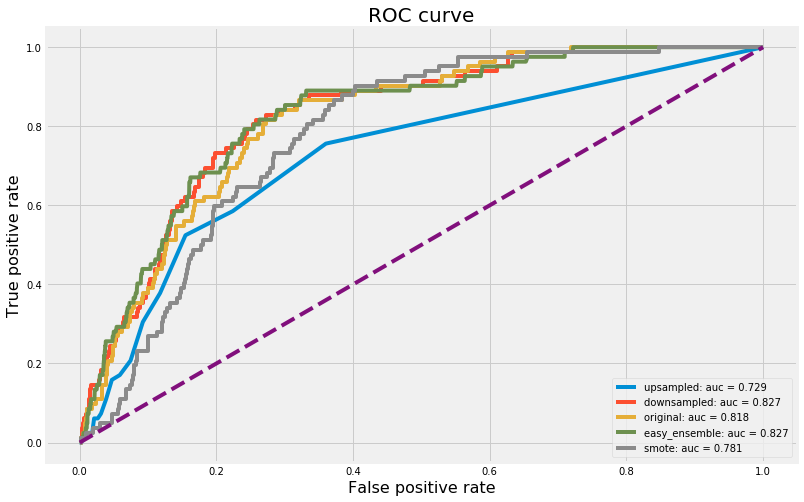

In [66]:
utils.plot_roc(models_dict, X_valid, y_valid, figure_size=(12, 8))

Clearly the upsampled model (oversampling) overfits the data which is not a surprise. Downsampled and easy ensemble have the same `auc` = 0.827 where downsample is a lot faster. Therefore, we will go with downsampled.

## KNearest Neighbors

In [69]:
# Build KNN classifier
pip_knn = Pipeline(steps=[
            ('transformers', col_transf),
            ('knn_clf', KNeighborsClassifier(n_jobs=-1))
            ])
hyperparam_range = range(1, 10)
gs_knn = GridSearchCV(pip_knn,
                      param_grid={'knn_clf__n_neighbors': hyperparam_range,
                                  'knn_clf__weights': ['uniform', 'distance']},
                      scoring='roc_auc',
                      cv=10,
                      n_jobs=-1)
gs_knn.fit(X_train_d, y_train_d)
print(f'The best hyperparameters:\n{"-" * 25}')
for hyperparam in gs_knn.best_params_.keys():
    print(hyperparam[hyperparam.find('__') + 2:], ': ', gs_knn.best_params_[hyperparam])
print(f'Best 10-folds CV roc_auc: {gs_knn.best_score_:.4f}.')

The best hyperparameters:
-------------------------
n_neighbors :  9
weights :  distance
Best 10-folds CV roc_auc: 0.8058.


## Logistic Regression

In [71]:
# Build logistic model classifier
pip_logreg = Pipeline(steps=[
        ('transformers', col_transf),
        ('logreg_clf', LogisticRegression(class_weight='balanced'))
        ])
hyperparam_range = np.arange(0.5, 20.1, 0.5)
hyperparam_grid = {'logreg_clf__penalty': ['l1', 'l2'],
                   'logreg_clf__C':  hyperparam_range,
                   'logreg_clf__fit_intercept': [True, False]
                  }
gs_logreg = GridSearchCV(pip_logreg,
                           hyperparam_grid,
                           scoring='roc_auc',
                           cv=10,
                           n_jobs=-1)
gs_logreg.fit(X_train_d, y_train_d)
print(f'The best hyperparameters:\n{"-" * 25}')
for hyperparam in gs_logreg.best_params_.keys():
    print(hyperparam[hyperparam.find('__') + 2:], ': ', gs_logreg.best_params_[hyperparam])
print(f'Best 10-folds CV roc_auc: {gs_logreg.best_score_:.4f}.')

The best hyperparameters:
-------------------------
C :  5.5
fit_intercept :  True
penalty :  l2
Best 10-folds CV roc_auc: 0.8519.


## SVM

In [104]:
# Build SVC
pip_svm_clf = Pipeline(steps=[
        ('transformers', col_transf),
        ('svm_clf', SVC(class_weight='balanced'))
        ])

hyperparam_grid = {'svm_clf__C':  [0.01, 0.1, 0.5, 1., 10.],
                   'svm_clf__gamma': [0.01, 0.1, 0.5, 1., 10., 'auto'],
                   'svm_clf__kernel': ['poly', 'rbf',],
                   'svm_clf__degree': [2, 3],
                   'svm_clf__coef0': [0., 0.1, 0.5, 1., 10.]
                  }
rs_svm_clf = RandomizedSearchCV(pip_svm_clf,
                      hyperparam_grid,
                      scoring='roc_auc',
                      n_iter=100,
                      cv=5,
                      n_jobs=-1)
rs_svm_clf.fit(X_train_d, y_train_d)

print(f'The best hyperparameters:\n{"-" * 25}')
for hyperparam in rs_svm_clf.best_params_.keys():
    print(hyperparam[hyperparam.find('__') + 2:], ': ', rs_svm_clf.best_params_[hyperparam])

print(f'Best 5-folds CV roc_auc: {rs_svm_clf.best_score_:.4f}.')

The best hyperparameters:
-------------------------
kernel :  poly
gamma :  auto
degree :  3
coef0 :  1.0
C :  0.5
Best 5-folds CV roc_auc: 0.8524.


## RandomForest

In [94]:
# Build random forest classifier
pip_rf = Pipeline(steps=[
    ('transformers', col_transf),
    ('rf_clf', RandomForestClassifier(class_weight='balanced',
                                      random_state=123))
])
    
hyperparam_grid = {
    'rf_clf__n_estimators': [50, 100, 300, 500],
    'rf_clf__max_features': ['sqrt', 'log2', 0.4, 0.5],
    'rf_clf__min_samples_leaf': [1, 3, 5],
    'rf_clf__criterion': ['gini', 'entropy']}

gs_rf = GridSearchCV(pip_rf,
                     hyperparam_grid,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=-1)
gs_rf.fit(X_train_d, y_train_d)

print(f'The best hyperparameters:\n{"-" * 25}')
for hyperparam in gs_rf.best_params_.keys():
    print(hyperparam[hyperparam.find('__') + 2:], ': ', gs_rf.best_params_[hyperparam])

print(f'Best 10-folds CV roc_auc: {gs_rf.best_score_:.2%}.')

The best hyperparameters:
-------------------------
criterion :  entropy
max_features :  sqrt
min_samples_leaf :  5
n_estimators :  300
Best 10-folds CV roc_auc: 84.63%.


## Extra Trees

In [96]:
# Build random forest classifier
pip_extra_trees = Pipeline(steps=[
    ('transformers', col_transf),
    ('extra_trees_clf', ExtraTreesClassifier(class_weight='balanced',
                                    random_state=123))
])

hyperparam_grid = {
    'extra_trees_clf__n_estimators': [10, 50, 100, 500],
    'extra_trees_clf__max_features': [0.1, 0.25, 0.5, 0.75, 'sqrt', 'log2', None],
    'extra_trees_clf__min_impurity_decrease': np.arange(0., 0.005, 0.00025),
    'extra_trees_clf__criterion': ['gini', 'entropy']}

rs_extra_trees = RandomizedSearchCV(pip_extra_trees,
                     hyperparam_grid,
                     scoring='roc_auc',
                     n_iter=500,
                     cv=10,
                     n_jobs=-1)
rs_extra_trees.fit(X_train_d, y_train_d)

print(f'The best hyperparameters:\n{"-" * 25}')
for hyperparam in rs_extra_trees.best_params_.keys():
    print(hyperparam[hyperparam.find('__') + 2:], ': ', rs_extra_trees.best_params_[hyperparam])

print(f'Best 10-folds CV roc_auc: {rs_extra_trees.best_score_:.2%}.')

The best hyperparameters:
-------------------------
n_estimators :  10
min_impurity_decrease :  0.00425
max_features :  0.5
criterion :  entropy
Best 10-folds CV roc_auc: 85.71%.


## XGBoost

In [97]:
# Build xgboost classifier
pip_xgb_clf = Pipeline(steps=[
        ('transformers', col_transf),
        ('xgb_clf', xgb.XGBClassifier(n_jobs=-1, seed=123))
        ])

hyperparam_grid = {'xgb_clf__n_estimators' : [50, 100, 200, 500],
                   'xgb_clf__learning_rate' : [0.01, 0.1, 0.5, 1.0],
                   'xgb_clf__gamma' : np.arange(0., 0.51, 0.05),
                   'xgb_clf__max_depth' : np.arange(3, 10, 1),
                   'xgb_clf__subsample' : np.arange(0.0, 1.01, 0.1),
                   'xgb_clf__colsample_bytree' : np.arange(0.1, 1.01, 0.1)}

rs_xgb_clf = RandomizedSearchCV(pip_xgb_clf,
                           hyperparam_grid,
                           scoring='roc_auc',
                           n_iter=500,
                           cv=10,
                           n_jobs=-1)
rs_xgb_clf.fit(X_train_d, y_train_d)

print(f'The best hyperparameters:\n{"-" * 25}')
for hyperparam in rs_xgb_clf.best_params_.keys():
    print(hyperparam[hyperparam.find('__') + 2:], ': ', rs_xgb_clf.best_params_[hyperparam])
print(f'Best 10-folds CV roc_auc: {rs_xgb_clf.best_score_:.4f}.')

The best hyperparameters:
-------------------------
subsample :  0.7000000000000001
n_estimators :  200
max_depth :  3
learning_rate :  0.01
gamma :  0.35000000000000003
colsample_bytree :  0.7000000000000001
Best 10-folds CV roc_auc: 0.8491.


## Stacked Ensembles

We tried various ensemble methods such Bagging (RF) and Boosting (XGBoost). Stacking usually helps in performance and most winners of Kaggle competitions use it as part of their pipleline. Here we will try two layers of stacking: the first one for base learners and the second for the meta-learner that will be trained based on the output of the base learners. Meta-learner will assign weights for each base learner based on CV. We will be pick the hyper-parameters from all the `GridSearch` we have done before.

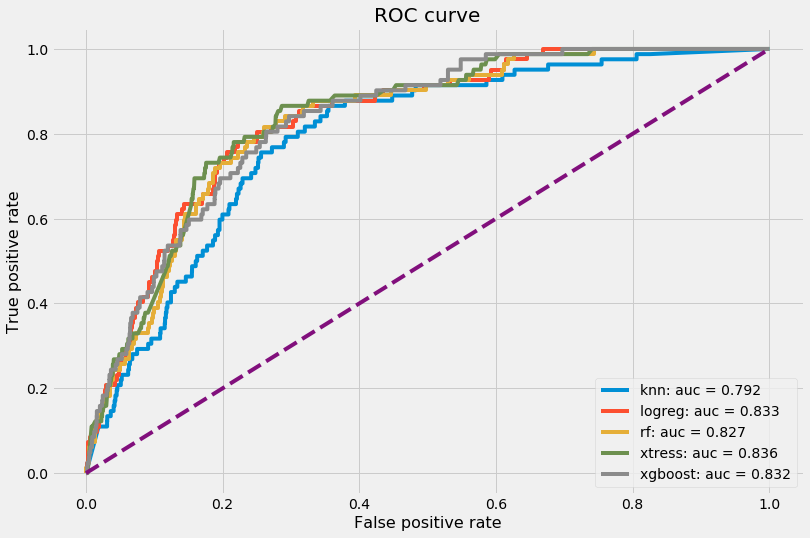

In [106]:
models = {
    'knn': gs_knn,
    'logreg': gs_logreg,
#     'svm': rs_svm_clf,
    'rf': gs_rf,
    'xtress': rs_extra_trees,
    'xgboost': rs_xgb_clf,
}
utils.plot_roc(models, X_valid, y_valid, (12, 8))

In [139]:
# Define base learners
knn_clf = KNeighborsClassifier(n_neighbors=9,
                               weights='distance',
                               n_jobs=-1)

logreg_clf = LogisticRegression(penalty='l2',
                                C=5.5,
                                fit_intercept=True,
                                class_weight='balanced',
                                n_jobs=-1)

svm_clf = SVC(C=0.5,
              kernel='poly',
              degree=3,
              coef0=1.0,
              gamma='auto',
              probability=True)

rf_clf = RandomForestClassifier(n_estimators=300,
                                criterion='entropy',
                                max_features='sqrt',
                                min_samples_leaf=3,
                                class_weight='balanced',
                                n_jobs=-1)

xtrees_clf = ExtraTreesClassifier(n_estimators=10,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_impurity_decrease=0.00425,
                                  class_weight='balanced',
                                  n_jobs=-1)

xgb_clf = xgb.XGBClassifier(subsample=0.7,
                            n_estimators=200,
                            max_depth=3,
                            learning_rate=0.01,
                            gamma=0.35,
                            colsample_bytree=0.7,
                            n_jobs=-1)

# Define meta-learner
logreg_clf_metalearner = LogisticRegression(penalty='l2',
                                            C=0.01,
                                            fit_intercept=True,
                                            class_weight='balanced',
                                            n_jobs=-1)

# Create Voting clf
voting_clf = VotingClassifier([('xgb', xgb_clf),
                               ('svm', svm_clf),
                               ('rf', rf_clf),
#                                ('knn', knn_clf),
                               ('logreg', logreg_clf),
                               ('xtrees', xtrees_clf)],
                               voting='soft',
                               flatten_transform=True)

# Build first stack of base learners
first_stack = make_pipeline(col_transf,
                            voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))

first_stack.fit(X_train_d, y_train_d)
# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack,
                                  X_train_d, y_train_d,
                                  cv=10,
                                  method='transform')

# Fit the meta learner
second_stack = logreg_clf_metalearner.fit(meta_features, y_train_d)
stacked_probs = second_stack.predict_proba(first_stack.transform(X_valid))[:, 1:]
np.round(roc_auc_score(y_valid, stacked_probs), 4)

0.8357

Looks like stacked ensembles have almost the same performance as xtrees classifier.

## Entity Embeddings

We won't use one-hot encoding as we did with the previous model; however, we will embed categorical features in a multidimensional space because categories are not independent (as implicitly was assumed with one-hot encoding) and let the embedding layers learn how the categories are related to each other - same concept as word embeddings. Therefore, we will keep categorical features as is plus we will convert `Hypertension_Status` and `Heart_Disease_Status` into object type by mapping `{1: 'Yes', 0: 'No'}`. 

### Preprocessing

In [332]:
df.head()

,PatientID,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
0,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
1,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
2,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
3,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
4,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [333]:
X_train_d[:5]

array([['Female', 46.0, 0, 0, 'Yes', 'Govt_job', 'Urban', 90.39, 27.0, 'never smoked'],
       ['Male', 70.0, 0, 0, 'Yes', 'Private', 'Urban', 90.23, 36.4, 'never smoked'],
       ['Female', 58.0, 0, 0, 'Yes', 'Private', 'Urban', 80.34, 25.5, 'never smoked'],
       ['Male', 82.0, 0, 1, 'Yes', 'Private', 'Urban', 144.9, 26.4, 'smokes'],
       ['Female', 69.0, 1, 0, 'Yes', 'Private', 'Rural', 120.45, 31.4, 'formerly smoked']], dtype=object)

In [334]:
X_train_d_v1 = X_train_d.copy()
# Convert Hypertension_Status and Heart_Disease_Status to object dtype
X_train_d_v1[:, 2:4][X_train_d_v1[:, 2:4] == 0] = 'No'
X_train_d_v1[:, 2:4][X_train_d_v1[:, 2:4] == 1] = 'Yes'
X_train_d_v1

array([['Female', 46.0, 'No', 'No', ..., 'Urban', 90.39, 27.0, 'never smoked'],
       ['Male', 70.0, 'No', 'No', ..., 'Urban', 90.23, 36.4, 'never smoked'],
       ['Female', 58.0, 'No', 'No', ..., 'Urban', 80.34, 25.5, 'never smoked'],
       ['Male', 82.0, 'No', 'Yes', ..., 'Urban', 144.9, 26.4, 'smokes'],
       ...,
       ['Male', 43.0, 'No', 'No', ..., 'Rural', 77.86, 28.9, 'never smoked'],
       ['Male', 11.0, 'No', 'No', ..., 'Urban', 97.71, 22.7, 'never smoked'],
       ['Male', 45.0, 'Yes', 'No', ..., 'Urban', 95.38, 50.0, 'never smoked'],
       ['Female', 30.0, 'No', 'No', ..., 'Urban', 85.51, 40.7, 'never smoked']], dtype=object)

In [335]:
y_train_d_v1 = y_train_d.copy().reshape(-1, 1)
data_d = np.concatenate([X_train_d_v1, y_train_d_v1], axis=1)
data_d

array([['Female', 46.0, 'No', 'No', ..., 90.39, 27.0, 'never smoked', 1],
       ['Male', 70.0, 'No', 'No', ..., 90.23, 36.4, 'never smoked', 1],
       ['Female', 58.0, 'No', 'No', ..., 80.34, 25.5, 'never smoked', 1],
       ['Male', 82.0, 'No', 'Yes', ..., 144.9, 26.4, 'smokes', 1],
       ...,
       ['Male', 43.0, 'No', 'No', ..., 77.86, 28.9, 'never smoked', 0],
       ['Male', 11.0, 'No', 'No', ..., 97.71, 22.7, 'never smoked', 0],
       ['Male', 45.0, 'Yes', 'No', ..., 95.38, 50.0, 'never smoked', 0],
       ['Female', 30.0, 'No', 'No', ..., 85.51, 40.7, 'never smoked', 0]], dtype=object)

In [336]:
data_d = pd.DataFrame(data_d, columns=[
    'Sex', 'Age', 'Hypertension_Status',
    'Heart_Disease_Status', 'Marital_Status',
    'Occupation', 'Residence', 'Mean_Glucose',
    'BMI', 'Smoking_Status', 'TIA'])
data_d.head()

,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
0,Female,46,No,No,Yes,Govt_job,Urban,90.39,27,never smoked,1
1,Male,70,No,No,Yes,Private,Urban,90.23,36.4,never smoked,1
2,Female,58,No,No,Yes,Private,Urban,80.34,25.5,never smoked,1
3,Male,82,No,Yes,Yes,Private,Urban,144.9,26.4,smokes,1
4,Female,69,Yes,No,Yes,Private,Rural,120.45,31.4,formerly smoked,1


In [337]:
cont_features

['Age', 'Mean_Glucose', 'BMI']

In [338]:
cat_features

['Sex', 'Marital_Status', 'Occupation', 'Residence', 'Smoking_Status']

In [339]:
cat_features_v1 = cat_features + ['Hypertension_Status', 'Heart_Disease_Status']
cat_features_v1

['Sex',
 'Marital_Status',
 'Occupation',
 'Residence',
 'Smoking_Status',
 'Hypertension_Status',
 'Heart_Disease_Status']

In [340]:
for col in cont_features:
    data_d[col] = data_d[col].astype('float')
data_d['TIA'] = data_d['TIA'].astype('int')
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 11 columns):
Sex                     768 non-null object
Age                     768 non-null float64
Hypertension_Status     768 non-null object
Heart_Disease_Status    768 non-null object
Marital_Status          768 non-null object
Occupation              768 non-null object
Residence               768 non-null object
Mean_Glucose            768 non-null float64
BMI                     768 non-null float64
Smoking_Status          768 non-null object
TIA                     768 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 66.1+ KB


In [341]:
X_valid_v1 = X_valid.copy()
# Convert Hypertension_Status and Heart_Disease_Status to object dtype
X_valid_v1[:, 2:4][X_valid_v1[:, 2:4] == 0] = 'No'
X_valid_v1[:, 2:4][X_valid_v1[:, 2:4] == 1] = 'Yes'

y_valid_v1 = y_valid.copy().reshape(-1, 1)
valid_data = np.concatenate([X_valid_v1, y_valid_v1], axis=1)
valid_data = pd.DataFrame(valid_data, columns=[
    'Sex', 'Age', 'Hypertension_Status',
    'Heart_Disease_Status', 'Marital_Status',
    'Occupation', 'Residence', 'Mean_Glucose',
    'BMI', 'Smoking_Status', 'TIA'])
valid_data.head()

,Sex,Age,Hypertension_Status,Heart_Disease_Status,Marital_Status,Occupation,Residence,Mean_Glucose,BMI,Smoking_Status,TIA
0,Male,35,No,No,Yes,Self-employed,Rural,77.1,32.8,smokes,0
1,Female,48,No,No,No,Govt_job,Urban,101.41,20.7,smokes,0
2,Female,31,No,No,No,Govt_job,Urban,182.63,41.8,never smoked,0
3,Female,79,Yes,No,Yes,Private,Rural,56.87,28.5,never smoked,0
4,Female,51,No,No,Yes,Self-employed,Rural,116.6,25.8,never smoked,0


In [342]:
valid_data.dtypes

Sex                     object
Age                     object
Hypertension_Status     object
Heart_Disease_Status    object
Marital_Status          object
Occupation              object
Residence               object
Mean_Glucose            object
BMI                     object
Smoking_Status          object
TIA                     object
dtype: object

In [343]:
for col in cont_features:
    valid_data[col] = valid_data[col].astype('float')
valid_data['TIA'] = valid_data['TIA'].astype('int')
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4360 entries, 0 to 4359
Data columns (total 11 columns):
Sex                     4360 non-null object
Age                     4360 non-null float64
Hypertension_Status     4360 non-null object
Heart_Disease_Status    4360 non-null object
Marital_Status          4360 non-null object
Occupation              4360 non-null object
Residence               4360 non-null object
Mean_Glucose            4360 non-null float64
BMI                     4360 non-null float64
Smoking_Status          4360 non-null object
TIA                     4360 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 374.8+ KB


### Modeling

In [344]:
data_bunch = (TabularList.from_df(data_d, path=PATH,
                                  cat_names=cat_features_v1,
                                  cont_names=cont_features,
                                  procs=procs)
                         .random_split_by_pct(0.2)
                         .label_from_df(cols='TIA')
                         .databunch())

In [345]:
data_bunch.show_batch()

Sex,Marital_Status,Occupation,Residence,Smoking_Status,Hypertension_Status,Heart_Disease_Status,Age,Mean_Glucose,BMI,target
Male,Yes,Self-employed,Urban,formerly smoked,No,Yes,0.9415,1.1613,0.3446,1
Female,Yes,Self-employed,Rural,never smoked,Yes,No,-0.3650,0.8753,0.1024,1
Female,Yes,Govt_job,Rural,never smoked,No,No,0.5234,-0.3969,-0.1826,0
Male,Yes,Private,Urban,smokes,No,Yes,1.2028,-0.9105,-0.8523,1
Male,Yes,Private,Urban,formerly smoked,No,No,0.2099,-0.3998,0.0597,0


In [358]:
learn = tabular_learner(data_bunch, layers=[1000, 500],
                        ps=[0.001, 0.01], emb_drop=0.04,
                        metrics=accuracy)

In [359]:
learn.lr_find()

epoch  train_loss  valid_loss  accuracy
1      0.715833              
2      0.707214              
3      0.683457              
4      0.634999              
5      0.609083              
6      0.581993              
7      0.567603              
8      0.580406              
9      3.104692              
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


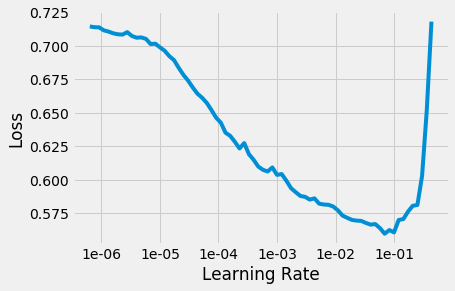

In [360]:
learn.recorder.plot()

Will use learning rate that has 1e-1 to the steepest slope before minimum to have faster convergence. Also, weight decay will help us avoid overfitting.

In [361]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch  train_loss  valid_loss  accuracy
1      0.606004    0.645744    0.758170
2      0.550705    0.624284    0.686275
3      0.529288    0.604515    0.686275
4      0.511000    0.547790    0.758170
5      0.500356    0.509583    0.745098


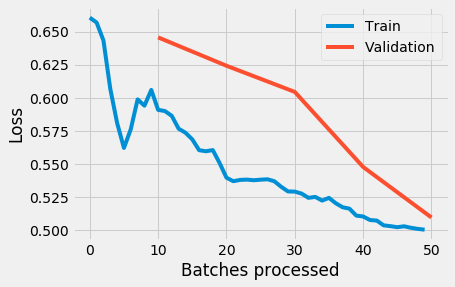

In [362]:
learn.recorder.plot_losses()

In [363]:
probs = []
for i in range(valid_data.shape[0]):
    row = valid_data.iloc[i]
    c, pred, prob = learn.predict(row)
    probs.append(prob.numpy()[1])
roc_auc_score(y_valid, np.array(probs))

0.8320277312170036

In [364]:
learn.save('entity-embedding-1')

In [369]:
learn.load('entity-embedding-1')
learn.fit_one_cycle(5, 1e-2)

epoch  train_loss  valid_loss  accuracy
1      0.513230    0.695887    0.751634
2      0.529693    0.486552    0.771242
3      0.525206    0.535196    0.699346
4      0.519938    0.469918    0.777778
5      0.504508    0.473269    0.738562


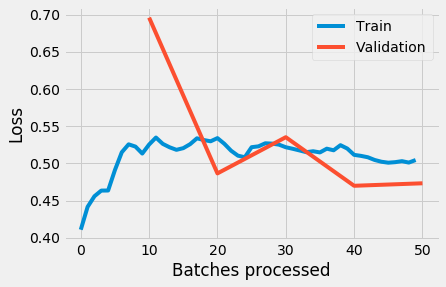

In [370]:
learn.recorder.plot_losses()

In [371]:
probs = []
for i in range(valid_data.shape[0]):
    row = valid_data.iloc[i]
    c, pred, prob = learn.predict(row)
    probs.append(prob.numpy()[1])
roc_auc_score(y_valid, np.array(probs))

0.833256365522982

In [373]:
learn.save('entity-embedding-2')

In [379]:
learn.load('entity-embedding-2')
learn.fit_one_cycle(5, 1e-5)

epoch  train_loss  valid_loss  accuracy
1      0.452748    0.473051    0.738562
2      0.456723    0.474266    0.732026
3      0.456392    0.475121    0.738562
4      0.456152    0.476017    0.738562
5      0.453866    0.475816    0.738562


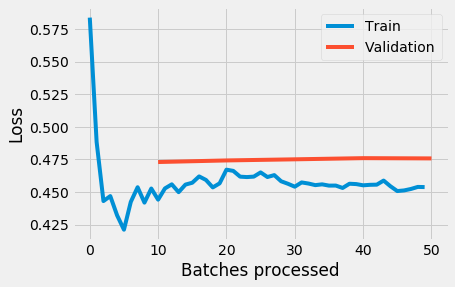

In [380]:
learn.recorder.plot_losses()

In [381]:
probs = []
for i in range(valid_data.shape[0]):
    row = valid_data.iloc[i]
    c, pred, prob = learn.predict(row)
    probs.append(prob.numpy()[1])
roc_auc_score(y_valid, np.array(probs))

0.8336896657886634

In [382]:
learn.save('entity-embedding-3')

In [357]:
learn.model.embeds[0].weight.data.numpy()

array([[ 0.006913,  0.006604],
       [ 0.011593, -0.011061],
       [ 0.001332,  0.00362 ]], dtype=float32)

In [330]:
learn.model.embeds

ModuleList(
  (0): Embedding(3, 2)
  (1): Embedding(3, 2)
  (2): Embedding(6, 4)
  (3): Embedding(3, 2)
  (4): Embedding(4, 3)
  (5): Embedding(3, 2)
  (6): Embedding(3, 2)
)

In [356]:
cat_features_v1

['Sex',
 'Marital_Status',
 'Occupation',
 'Residence',
 'Smoking_Status',
 'Hypertension_Status',
 'Heart_Disease_Status']

## Re-tune Best Algorithm

Looks like `ExtreTreesClassifier` yielded the best performance with around 0.836 `auc` score. So we will pick this algorithm and try to work on some thing to see if we can make it perform better. The steps that we will take goes as follow:
- Re-run it on the training data
- Compute feature importances to see if some features don't have any predictive power. Note that we won't use `sklearn's` feature importance because it is biased towards continuous features especially those who have high cardinality. However, we will use feature importance based on permutation where we iterate over all features and randomly shuffling each feature one at a time and compare the base accuracy to the accuracy with the randomly shuffled feature. This way we know the importance of each feature without worrying about the bias.
- We will also compute the correlation between features using two methods:
    - Spearman correlation. It is more robust than pearson correlation because it is non-parametric and assumes no linearity on the data.
    - Hierachical clustering on feature-based matrices (not observations-based) to see what features are close to each other.
- Try remove correlated and non-important features one at a time and see if this adds to the overall performance on validation set.
- Refit the algorithm on both training and validation sets.
- Evaluate it on test data.

### Feature Selection

In [448]:
# Make column transformer
col_transf = ColumnTransformer(
    [('rob_scaler', RobustScaler(), cont_features_idxs),
    ('ohe', OneHotEncoder(handle_unknown='ignore', categories=categories), cat_features_idxs)
    ], remainder='passthrough'
)

In [460]:
xtrees_clf = ExtraTreesClassifier(n_estimators=10,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_impurity_decrease=0.00425,
                                  class_weight='balanced',
                                  n_jobs=-1)
pip_xtrees_clf = make_pipeline(col_transf, xtrees_clf)
pip_xtrees_clf.fit(X_train_d, y_train_d)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('rob_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), [1, 7, 8]), ('ohe',...imators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [461]:
feat_imp = pip_xtrees_clf.steps[1][1].feature_importances_
feat_imp

array([0.49858 , 0.06292 , 0.00524 , 0.01442 , 0.      , 0.080141, 0.      , 0.      , 0.033346, 0.      , 0.002032,
       0.012754, 0.008276, 0.132224, 0.150068])

In [452]:
col_transf.named_transformers_['ohe'].categories

[array(['Male', 'Other'], dtype=object),
 array(['Yes'], dtype=object),
 array(['Never_worked', 'Private', 'Self-employed', 'children'], dtype=object),
 array(['Urban'], dtype=object),
 array(['never smoked', 'smokes'], dtype=object)]

In [496]:
feat_names = [
    'Age', 'Mean_Glucose', 'BMI',
    'Sex_Male', 'Sex_Other', 'Marital_Status_Yes',
    'Occupation_Never_worked', 'Occupation_Private',
    'Occupation_Self-employed', 'Occupation_children',
    'Residence_Urban', 'Smoking_Status_never smoked',
    'Smoking_Status_smokes', 'Hypertension_Status', 'Heart_Disease_Status'
]

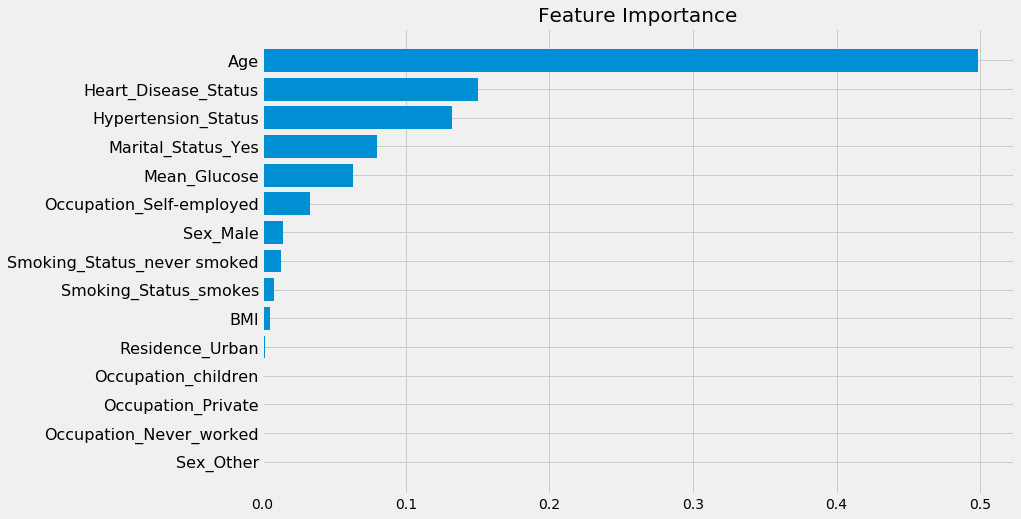

In [462]:
utils.plot_feature_imp(feat_imp, feat_names);

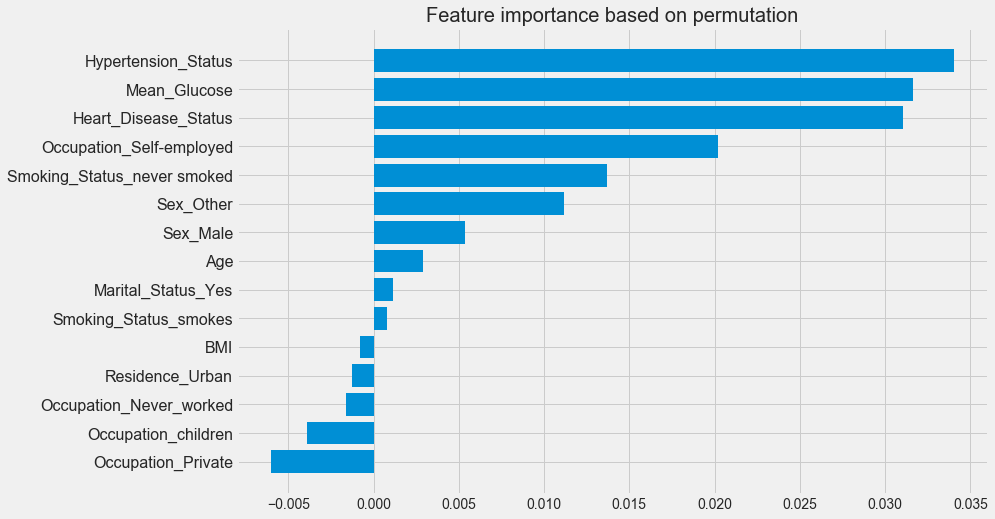

In [510]:
feat_imp_perm = utils.permutation_importances_cv(pip_xtrees_clf,
                                                 X_train_trans, y_train_d,
                                                 scoring='roc_auc',
                                                 k=5)

utils.plot_feature_imp(feat_imp_perm, feat_names, title='Feature importance based on permutation');

In [467]:
# Transform train data to compute correlation between features.
X_train_trans = col_transf.fit_transform(X_train_d)
X_train_trans_df = pd.DataFrame(X_train_trans, columns=feat_names)
X_train_trans_df.head()

,Age,Mean_Glucose,BMI,Sex_Male,Sex_Other,Marital_Status_Yes,Occupation_Never_worked,Occupation_Private,Occupation_Self-employed,Occupation_children,Residence_Urban,Smoking_Status_never smoked,Smoking_Status_smokes,Hypertension_Status,Heart_Disease_Status
0,-0.466667,-0.105165,-0.270769,0,0,1,0,0,0,0,1,1,0,0,0
1,0.333333,-0.107754,0.886154,1,0,1,0,1,0,0,1,1,0,0,0
2,-0.0666667,-0.267767,-0.455385,0,0,1,0,1,0,0,1,1,0,0,0
3,0.733333,0.776767,-0.344615,1,0,1,0,1,0,0,1,0,1,0,1
4,0.3,0.381184,0.270769,0,0,1,0,1,0,0,0,0,0,1,0


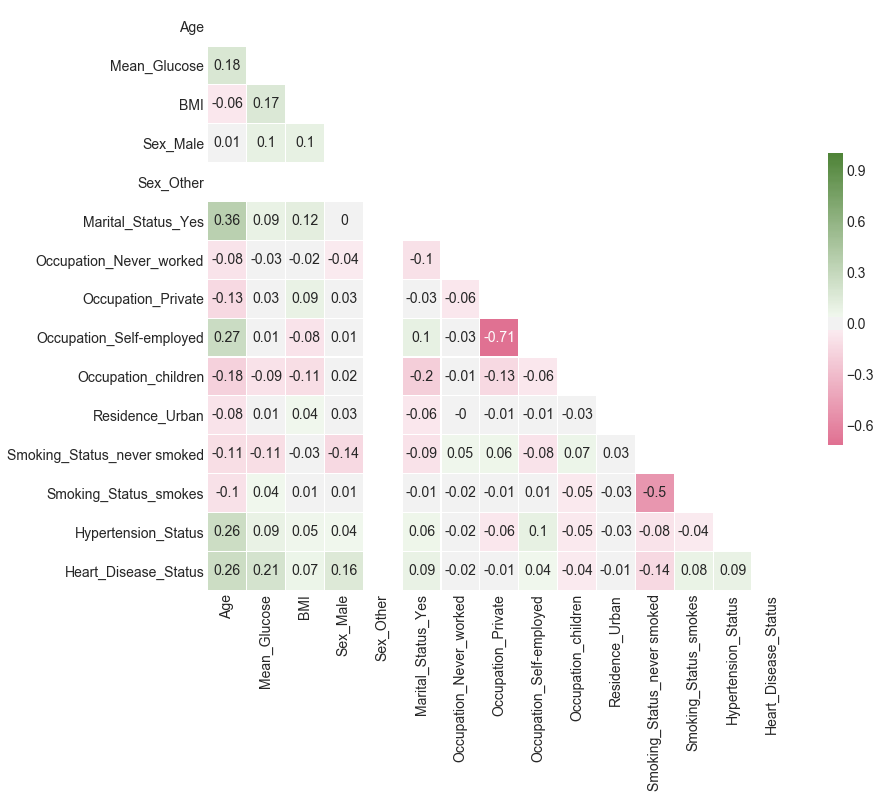

In [470]:
utils.plot_corr_matrix(X_train_trans_df, method='spearman', figsize=(12, 10))

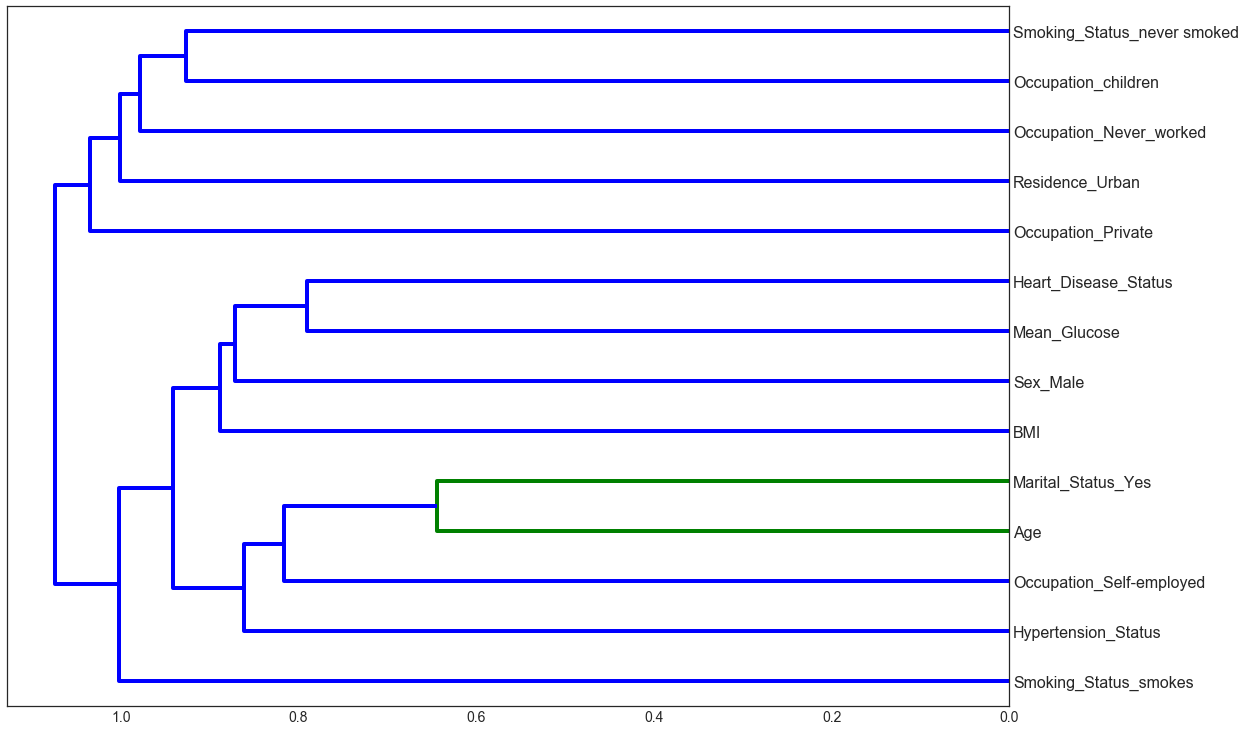

In [501]:
# Remove Sex_Other
feat_names_v1 = feat_names[:]
feat_names_v1.remove('Sex_Other')
utils.plot_feature_based_hier_clustering(np.delete(X_train_trans, 4, axis=1),
                                         feat_names_v1,
                                         linkage_method='average')

Now we will try the features that didn't add predictability to classifier and see how this would affect the performance. Note that there was no features that have very high correlation (> 0.9).

In [517]:
to_drop_cols = [
    'BMI', 'Sex_Other', 'Occupation_Never_worked',
    'Occupation_Private', 'Occupation_children', 'Residence_Urban'
]
X_valid_trans = col_transf.transform(X_valid)

In [530]:
np.round(roc_auc_score(y_valid, pip_xtrees_clf.predict_proba(X_valid)[:, 1]), 4)

0.8217

In [636]:
for col in to_drop_cols:
    col_idx = feat_names.index(col)
    temp_train = np.delete(X_train_trans, col_idx, axis=1)
    temp_valid = np.delete(X_valid_trans, col_idx, axis=1)
    xtrees_clf = ExtraTreesClassifier(n_estimators=10,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_impurity_decrease=0.00425,
                                  class_weight='balanced',
                                  n_jobs=-1)
    xtrees_clf.fit(temp_train, y_train_d)
    score = roc_auc_score(y_valid, xtrees_clf.predict_proba(temp_valid)[:, 1])
    print(f'{col} : {score:.4f}')

BMI : 0.8191
Sex_Other : 0.8236
Occupation_Never_worked : 0.8322
Occupation_Private : 0.8378
Occupation_children : 0.8160
Residence_Urban : 0.8213


In [531]:
[feat_names.index(col) for col in to_drop_cols]

[2, 4, 6, 7, 9, 10]

In [643]:
temp_train = np.delete(X_train_trans, [4, 6, 7], axis=1)
temp_valid = np.delete(X_valid_trans, [4, 6, 7], axis=1)
xtrees_clf = ExtraTreesClassifier(n_estimators=10,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_impurity_decrease=0.00425,
                                  class_weight='balanced',
                                  n_jobs=-1)
xtrees_clf.fit(temp_train, y_train_d)
score = roc_auc_score(y_valid, xtrees_clf.predict_proba(temp_valid)[:, 1])
print(f'{col} : {score:.4f}')

Residence_Urban : 0.8228


We will drop the following features:
- Sex_Other
- Occupation_Never_worked
- Occupation_Private

In [638]:
categories_new = categories[:]
categories_new

[array(['Male', 'Other'], dtype=object),
 array(['Yes'], dtype=object),
 array(['Never_worked', 'Private', 'Self-employed', 'children'], dtype=object),
 array(['Urban'], dtype=object),
 array(['never smoked', 'smokes'], dtype=object)]

In [639]:
categories_new[0] = np.delete(categories_new[0], 1)
categories_new[2] = np.delete(categories_new[2], [0, 1])
categories_new

[array(['Male'], dtype=object),
 array(['Yes'], dtype=object),
 array(['Self-employed', 'children'], dtype=object),
 array(['Urban'], dtype=object),
 array(['never smoked', 'smokes'], dtype=object)]

In [640]:
# Make column transformer
col_transf_new = ColumnTransformer(
    [('rob_scaler', RobustScaler(), cont_features_idxs),
    ('ohe', OneHotEncoder(handle_unknown='ignore', categories=categories_new),
     cat_features_idxs)
    ], remainder='passthrough'
)

In [641]:
col_transf_new.fit_transform(X_train_d).shape

(768, 12)

In [642]:
col_transf_new.named_transformers_['ohe'].categories

[array(['Male'], dtype=object),
 array(['Yes'], dtype=object),
 array(['Self-employed', 'children'], dtype=object),
 array(['Urban'], dtype=object),
 array(['never smoked', 'smokes'], dtype=object)]

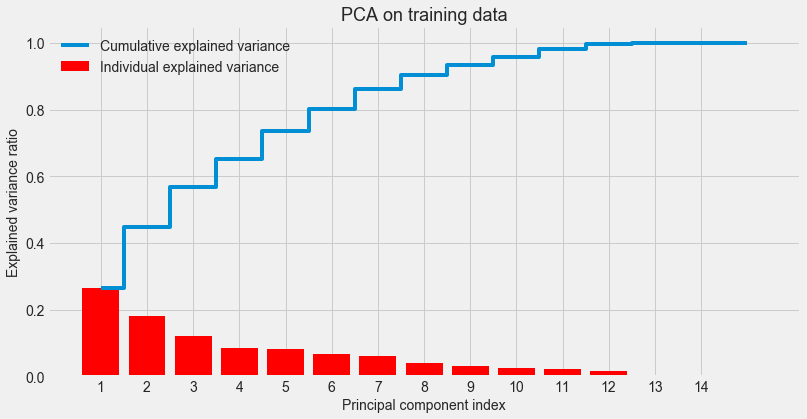

In [574]:
pca = PCA()
pca.fit(X_train_trans)
utils.plot_pca_var_explained(pca)

In [543]:
preds = xtrees_clf.predict(temp_valid)
probs = xtrees_clf.predict_proba(temp_valid)
fp_idxs = (y_valid == 0) & (preds == 1)
fn_idxs = (y_valid == 1) & (preds == 0)

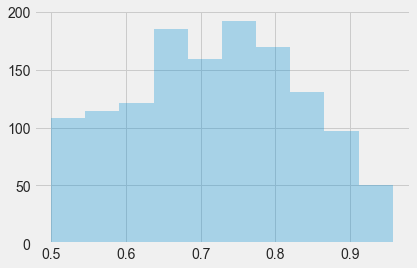

In [558]:
# plt.hist(probs, alpha=0.3)
plt.hist(probs[fp_idxs, 1], alpha=0.3);

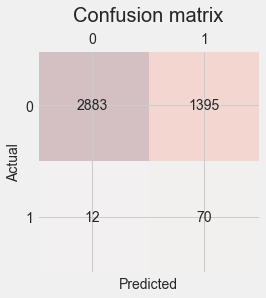

In [665]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_valid, xtrees_clf.predict_proba(temp_valid)[:, 1] > 0.5)
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

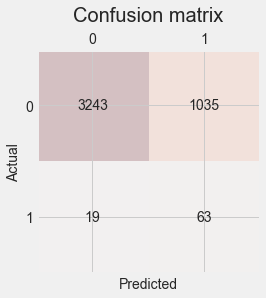

In [666]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_valid, xtrees_clf.predict_proba(temp_valid)[:, 1] > 0.6)
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

Looks like we have a very high *False Positive Rates*. **0.6** looks good as a cutoff to reduce FPR at the expense of increasing *False Negative Rates* which in this case are a lot more dangerous than FPR. The best we can do is assign a weight to both FP and FN and get the value that leads to the best combination.

## Refit on Training and Validation Data

In [629]:
X_valid.shape, y_valid.shape

((4360, 10), (4360,))

In [630]:
# Downsample the validing data
X_valid_d, y_valid_d = resample(X_valid[y_valid == 0],
                                y_valid[y_valid == 0],
                                replace=True,
                                n_samples=X_valid[y_valid == 1].shape[0],
                                random_state=1)
X_valid_d = np.concatenate((X_valid[y_valid == 1], X_valid_d))
y_valid_d = np.concatenate((y_valid[y_valid == 1], y_valid_d))
X_valid_d.shape, y_valid_d.shape

((164, 10), (164,))

In [645]:
X_train_final = np.concatenate([X_train_d, X_valid_d], axis=0)
y_train_final = np.concatenate([y_train_d, y_valid_d], axis=0)
X_train_final.shape, y_train_final.shape

((932, 10), (932,))

In [644]:
xtrees_clf = ExtraTreesClassifier(n_estimators=10,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_impurity_decrease=0.00425,
                                  class_weight='balanced',
                                  n_jobs=-1)

pip_extra_trees_clf = Pipeline(steps=[
    ('transformers', col_transf_new),
    ('extra_trees_clf', xtrees_clf)
])

In [646]:
pip_extra_trees_clf.fit(X_train_final, y_train_final)

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('rob_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), [1, 7, 8]), ('ohe', OneH...imators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

## Evaluation on Test data

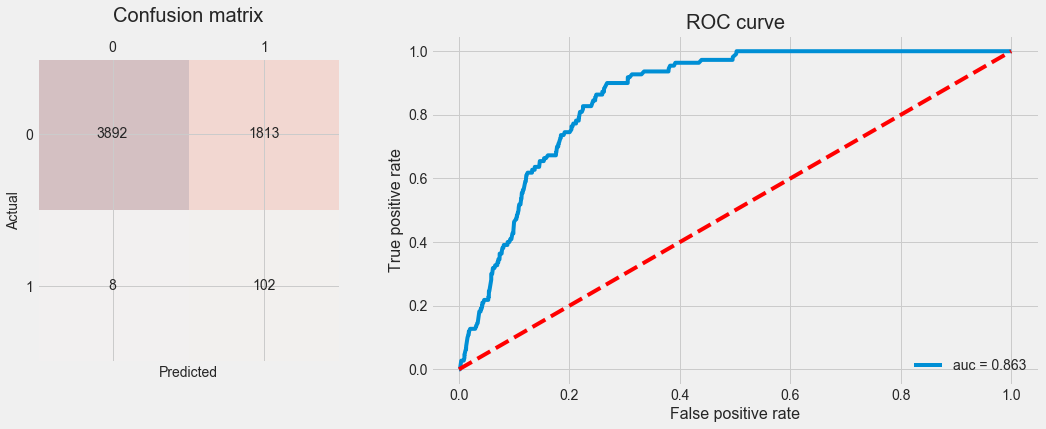

In [649]:
utils.plot_conf_matrix_and_roc(pip_extra_trees_clf, X_test[:, 1:], y_test)

The test **AUC** score = 0.863

In [652]:
acc = accuracy_score(y_test, pip_extra_trees_clf.predict(X_test[:, 1:]))
print(f'The test accuracy : {acc:.2%}')

The test accuracy : 68.68%


In [667]:
preds = pip_extra_trees_clf.predict_proba(X_test[:, 1:])[:, 1]
confusion_matrix(y_test, preds > 0.6)

array([[4384, 1321],
       [  19,   91]])

In [669]:
accuracy_score(y_test, preds > 0.6)

0.7695614789337919

## Serialize to disk

In [699]:
joblib.dump(pip_extra_trees_clf, '../models/final-model')
joblib.dump(col_transf_new, '../models/col-transformers')
joblib.dump(categories_new, '../models/categories')
joblib.dump(cont_features_idxs, '../models/cont-feat-idxs')
joblib.dump(cat_features_idxs, '../models/cat-feat-idxs')
joblib.dump(feat_names, '../models/feat-names-orig')
joblib.dump(feat_names_v1, '../models/feat-names-v1')
joblib.dump(df.columns.values.tolist()[:-1], '../models/column-names')

['../models/column-names']

# Conclusion

According to clinical researches, about 1 in 3 people who had a TIA had a stroke within a year. So it is very important to be able to predict the likelihood of patients to have it so we can take actions to prevent it from happening. This will save the health care system money and prevent harm on out patients.

The best ML models has an **AUC** score = 0.863 on unseen data. The dataset is highly imbalanced which is not unusual in clinical settings and becomes a challenge to find a ML model that is not biased to the majority class (patients with no TIA). Three of the most important features were: 1) Whether a patient suffers from hypertension, 2) Average glucose level, and 3) Whether a patient suffers from heart diseases. These among other conditions coincides with what clinical researches shows that they were symptoms for TIA's.

Things that are worth considering as next steps (if time/computation resources permit):
1. Use the entity embeddings learned from categorical features and feed it into shallow ML algorithms such as RandomForest or XGBoost instead of one-hot encoding.
2. Try collect more features for patients that clinical researches showed are correlated with TIA such as:
    - Cholestrol level.
    - Race.
    - Family history.
    - Previous TIA.
3. Use nested cross-validation when doing hyper-parameter optimization which is proven to give a non-biased (or a lot lower bias) that just taking the model with the best cross-validation score.
4. Try to assign weight of both false positive rates and false negative rates and pick a threshold that leads to the optimal trade-off.
5. Use *Deep Feature Synthesis* algorithm to generate a lot more features.